In [1]:
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch
import time
import datetime
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

seed = 449
random.seed(seed)
torch.manual_seed(seed)
writer = SummaryWriter(flush_secs=20)

#in cmd: tensorboard --logdir runs
#http://localhost:6006/#

In [17]:
#import diffusion utilities and UNET
from diffusion import diffusion_process, denoise_net, diff_model
from modules import UNet_conditional

100%|██████████| 170498071/170498071 [00:05<00:00, 29469632.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


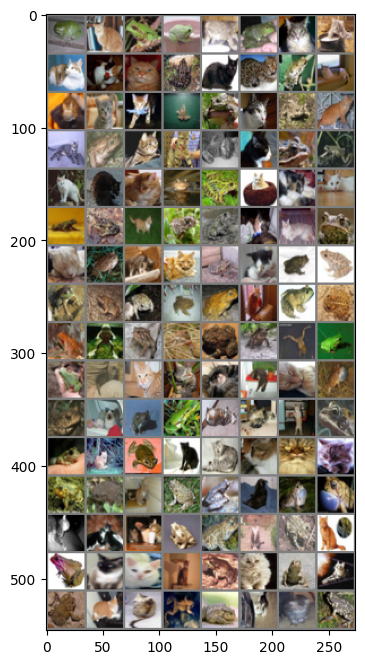

In [3]:
#import dataset
from torchvision.transforms.autoaugment import TrivialAugmentWide
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cat_idxs = np.where((np.array(trainset.targets) == 3))[0]
frog_idxs = np.where((np.array(trainset.targets) == 6))[0]
idxs = np.concatenate((cat_idxs, frog_idxs))
two_class_set = torch.utils.data.Subset(trainset, idxs)
two_class_loader = torch.utils.data.DataLoader(two_class_set, batch_size=batch_size, shuffle=True, num_workers=2)



# functions to show an image
def imshow(img, title="", unnormalize = True):
    if unnormalize:
      img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
def imsave(img, path):
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    path = path + "-image.png"
    plt.imsave(path, img)

dataiter = iter(two_class_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [4]:
batch_size = 128
image_size = 32

#number of time steps in diffusion process
T = 1000

#beta schedule for the forward process
beta_0 = .0001
beta_T = .02


num_epochs = 1000
lr = 0.0003
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
#Initialize the model

net = UNet_conditional(num_classes = 10, device = device)

dif_proc = diffusion_process(T, beta_0, beta_T)
denoising_net = denoise_net(dif_proc, net)

def prior(size):
  """
  just samples from a Gaussian, though in theory could be something different
  """
  z = torch.randn(size)
  return z


model = diff_model(dif_proc, denoising_net, device = device)
model.denoiser.net.to(device)

#use AdamW with specified learning rate - everything else is default.
optimizer = torch.optim.AdamW(denoising_net.net.parameters(), lr=lr)

#setup the tensorboard
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

In [8]:
"""
The training loop.
"""
losses = []

def train(epochs, dataloader, opt, model):
  tot_loss = torch.zeros(epochs).to(device)
  img_list = []
  model.denoiser.net.train()
  mse = torch.nn.MSELoss()
    
  start_time = time.time()

  for i in range(epochs):
    for batch, labels in dataloader:
      batch_size = batch.size(0)
      t = torch.randint(1, model.T, (batch_size,))
      x_t, eps = model.dif_proc(batch, t)

      t = t.to(device)
      x_t = x_t.to(device)
      eps = eps.to(device)
                     
      opt.zero_grad()
      loss = mse(eps, model.denoiser.net(x_t, t, labels.to(device)))
      loss.backward()
      opt.step()
      tot_loss[i] += loss.detach()

    #tracking stats in tensorboard
    if i%10 == 0:
      writer.add_scalar("loss", tot_loss[i], i)
      losses.append(tot_loss[i])

    if i%100 == 0:
      path = "conditional_experiment_1_epoch" + str(i)
      torch.save(model.denoiser.net.state_dict(), path)
        
    print("epoch = {} loss={:.6f}".format(i, tot_loss[i]))
  writer.flush()
  writer.close()

  model.denoiser.net.eval()
  #os.makedirs("models")
  #torch.save(model.denoiser.net.state_dict(), path)

In [9]:
train(num_epochs, two_class_loader, optimizer, model)

epoch = 0 loss=30.808849
epoch = 1 loss=9.803766
epoch = 2 loss=7.124316
epoch = 3 loss=5.678335
epoch = 4 loss=5.179691
epoch = 5 loss=4.661896
epoch = 6 loss=4.404236
epoch = 7 loss=4.243262
epoch = 8 loss=4.027507
epoch = 9 loss=3.965030
epoch = 10 loss=3.947206
epoch = 11 loss=3.787969
epoch = 12 loss=3.635077
epoch = 13 loss=3.683799
epoch = 14 loss=3.597948
epoch = 15 loss=3.564301
epoch = 16 loss=3.567149
epoch = 17 loss=3.413295
epoch = 18 loss=3.583040
epoch = 19 loss=3.339751
epoch = 20 loss=3.488963
epoch = 21 loss=3.386642
epoch = 22 loss=3.367573
epoch = 23 loss=3.267881
epoch = 24 loss=3.280218
epoch = 25 loss=3.390270
epoch = 26 loss=3.303089
epoch = 27 loss=3.280397
epoch = 28 loss=3.185248
epoch = 29 loss=3.300858
epoch = 30 loss=3.218662
epoch = 31 loss=3.131256
epoch = 32 loss=3.288059
epoch = 33 loss=3.213425
epoch = 34 loss=3.132010
epoch = 35 loss=3.255318
epoch = 36 loss=3.189308
epoch = 37 loss=3.195183
epoch = 38 loss=2.971743
epoch = 39 loss=3.048419
epoch = 4

In [10]:
torch.save(model.denoiser.net.state_dict(), "conditional_experiment_1_epoch1000")

In [43]:
class_label = torch.tensor([6])
noise = torch.randn(3,32,32)
batch_size = 32
device = "cuda"

with torch.no_grad():
            im = torch.randn((batch_size, 3, 32, 32)).to(device)
    
            for i in reversed(range(model.T)):
                if i > 1:
                    z = torch.randn_like(im).to(device)
                else:
                    z = torch.zeros(im.size()).to(device)
                y = class_label
                t = (torch.ones(batch_size)*i).long()
                alpha = (1 - model.dif_proc.variance_schedule[t]).view(-1,1,1,1).to(device)
                alpha_bar = (1 - model.dif_proc.forward_var(t)).view(-1,1,1,1).to(device)
                sigma = torch.sqrt(1-alpha) #this is a choice - see section 3.2 of Ho et al

                pred_noise = model.denoiser.net(im, t.to(device), y.to(device))

                im = 1/torch.sqrt(alpha)*(im - ((1-alpha)/torch.sqrt(1-alpha_bar))*pred_noise) + sigma*z

            im = (torch.clamp(im, -1, 1)+1)/2
            im = (im*255).type(torch.uint8)

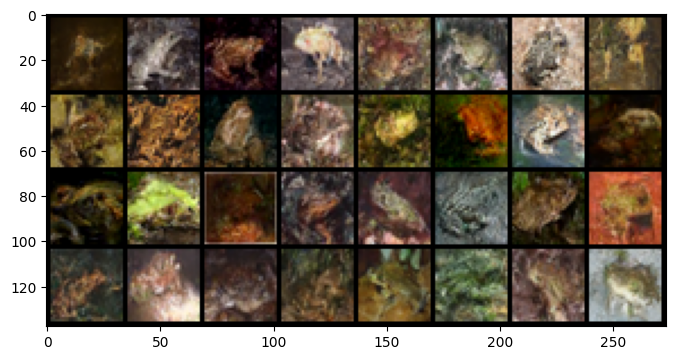

In [44]:

imshow(torchvision.utils.make_grid(im.cpu()), unnormalize = False)